# Merging Climate Datasets Exercise

Work through this notebook to practice harmonizing and merging two climate datasets that differ in temporal cadence and spatial resolution.

You will: 
- Load two public NOAA datasets directly from the cloud
- Subset to the continental US (use 230°E–300°E in longitude since the data span 0–360°)
- Use `xr.resample` to aggregate time and `xr.interp` to match grids
- Combine the variables with `xr.merge` for joint analysis

Refer back to the answer key after attempting each step.


## 1. Setup


In [22]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    ccrs = None
    cfeature = None

TEMP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.2020.nc"
PRECIP_URL = "https://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_precip/precip.2020.nc"

LAT_RANGE = (20, 50)  # degrees North
LON_RANGE_360 = (230, 300)  # degrees East (equivalent to -130° to -60°)
LON_RANGE_180 = (-130, -60)  # convenience if a dataset uses -180° to 180°

TIME_RANGE = slice("2020-06-01", "2020-06-30")


## 2. Load the datasets

Open both remote datasets with `xr.open_dataset`, passing a reasonable chunk size for the time dimension. Assign the resulting objects to `air` and `precip`.


In [3]:
# Load the air temperature and precipitation datasets.
air = xr.open_dataset(TEMP_URL, chunks = {"time": 8})
precip = xr.open_dataset(PRECIP_URL, chunks = {"time": 8})


## 3. Subset to the continental United States and June 2020

Select the bounding box provided above and limit the time range to June 2020 for both datasets. Store the results in `air_us` and `precip_us`.
Remember that longitude runs from 0° to 360°, so select 230°E–300°E. Check whether each coordinate is ascending or descending before building the slice.


In [4]:
# Subset both datasets using `sel`, handling coordinate ordering as needed.
air_us = air.sel(time = air.time.dt.month == 6, lat = slice(50, 20), lon = slice(230, 300))
precip_us = precip.sel(time = precip.time.dt.month == 6, lat = slice(50, 20), lon = slice(230, 300))


## 4. Align temporal cadence

Aggregate the six-hourly air temperatures to daily means with `xr.resample`. Name the resulting DataArray `air_daily`.


In [5]:
# Use xr.resample to create daily means.
air_us = air_us.resample(time = '1D').mean()
precip_us = precip_us.resample(time = '1D').mean()


## 5. Interpolate to the precipitation grid

Use `xr.interp` to interpolate the daily air temperatures onto the precipitation grid (`precip_us.lat` and `precip_us.lon`). Store the interpolated result in `air_interp`.


In [6]:
# Interpolate the resampled temperature field onto the precipitation grid.
air_us_interp = air_us.interp(lat = precip_us.lat, lon = precip_us.lon)


## 6. Merge the datasets

Convert the aligned arrays into datasets with clear variable names and merge them with `xr.merge`. Save the output as `merged`.


In [7]:
# Build datasets and merge them into one object named `merged`.
merged = xr.merge([air_us_interp, precip_us], join = "outer")


## 7. Inspect your result

Once your pipeline runs without `NotImplementedError`, evaluate the following cell to sanity-check the merged dataset.


In [8]:
# The assertions below should pass once you have completed the exercise.
assert set(merged.data_vars) == {"air", "precip"}
assert merged.air.dims == merged.precip.dims
print(merged)


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 30, lat: 60, lon: 140)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-06-01 2020-06-02 ... 2020-06-30
  * lat      (lat) float32 240B 49.75 49.25 48.75 48.25 ... 21.25 20.75 20.25
  * lon      (lon) float32 560B 230.2 230.8 231.2 231.8 ... 298.8 299.2 299.8
Data variables:
    air      (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
    precip   (time, lat, lon) float32 1MB dask.array<chunksize=(1, 60, 140), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (2014)
    history:                         created 2017/12 by Hoop (netCDF2.3)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    dataset_title:                   NCEP-NCAR Reanalysis 1
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    References:            

## 8. Check In

- Render both variables at the first timestep on a `cartopy` map to verify alignment visually (PlateCarree works well).
- Build a scatter plot comparing colocated temperature and precipitation values across the merged domain.
- Save the merged output with `to_netcdf` for future analysis.


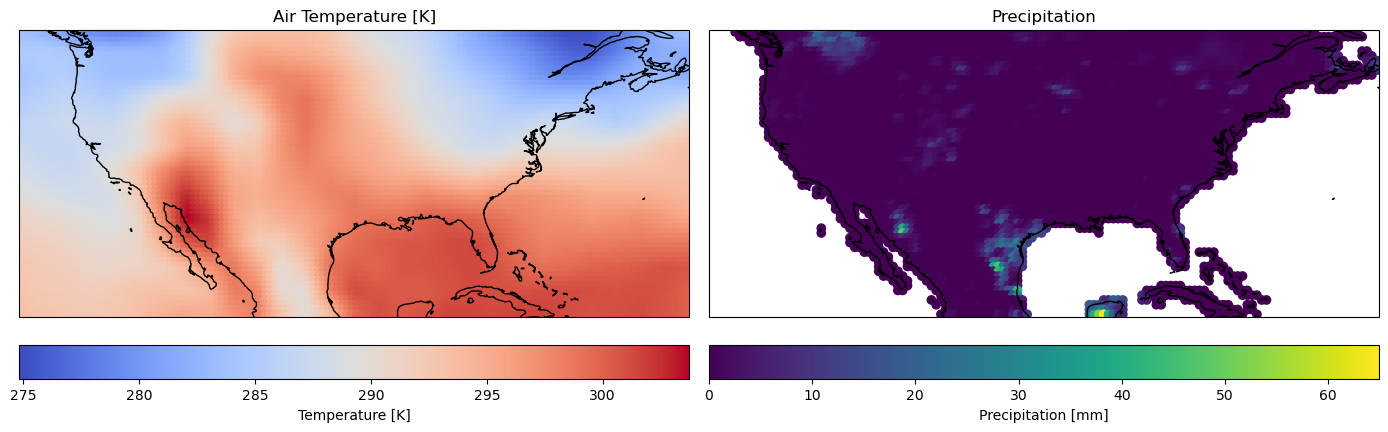

In [ ]:
# Render both variables at the first timestep on cartopy to verify the map
# Build a scatter plot comparing colocated temperature and precipitation values across the domain

fig, axs = plt.subplots(1, 2, figsize = (14, 6), subplot_kw = {'projection': ccrs.PlateCarree()})

# Take the first time step
temp0 = merged['air'].isel(time = 0).values
precip0 = merged['precip'].isel(time=0).values  

# Build 2D lon/lat grids
lon2d, lat2d = np.meshgrid(merged['lon'].values, merged['lat'].values)

# Temperature plot
axs[0].coastlines()
axs[0].set_extent([230, 300, 20, 50], crs = ccrs.PlateCarree())
sc1 = axs[0].scatter(
    lon2d.ravel(), lat2d.ravel(), 
    c = temp0, cmap = 'coolwarm',
    transform = ccrs.PlateCarree()
)
axs[0].set_title("Air Temperature [K]")
fig.colorbar(sc1, ax = axs[0], orientation = "horizontal", pad = 0.05, label = 'Temperature [K]')

# Precipitation plot
axs[1].coastlines()
axs[1].set_extent([230, 300, 20, 50], crs = ccrs.PlateCarree())
sc2 = axs[1].scatter(
    lon2d.ravel(), lat2d.ravel(), 
    c = precip0, cmap = 'viridis',
    transform = ccrs.PlateCarree()
)
axs[1].set_title("Precipitation")
fig.colorbar(sc2, ax = axs[1], orientation = "horizontal", pad = 0.05, label = 'Precipitation [mm]')

plt.tight_layout()
plt.show()

In [ ]:
# Save the merged output using to_netcdf for future analysis
merged.to_netcdf('June2020_module3.nc')